# Lesson 1: Working with Data from TNC S3

**Objective:** Interact with geospatial dataset stored within AWS `S3` buckets, an industry standard cloud storage solution.

### Amazon Web Services

[Amazon Web Services, AWS](https://aws.amazon.com/) is an industry standard provider of cloud compute and storage services. AWS provides services for [storage (`S3`)](https://aws.amazon.com/pm/serv-s3), [data analysis (such as the `SageMaker`](https://aws.amazon.com/sagemaker/) instance being used here), and [traditional relational database deployments (`RDS`)](https://aws.amazon.com/rds/) amongst numerous other offerings.

At TNC, with regards to Geospatial use cases, AWS powers our Remote Desktop Nimbus (aka GeoCloud) environments and Lacus EO storage bucket, as examples.

### S3 Buckets Overview

S3 bucket contents are similar to a local file system structure with slightly different terminology. All files are referred to as `objects` in an S3 bucket. Objects can be grouped together using `prefixes` which act similarly to folders.

We can view the contents of an S3 bucket that we have permissions for in a few different ways including, python, the command line (CLI), or via a web UI console. **For this exercise, we'll be using Python, but for reference we'll list the same commands that can be executed from the CLI.** Please see the `Additional Resources` section below for supplementary info on accessing S3 via all of these modes.

**Costs:** AWS S3 costs depend on a few different factors. Full pricing information can be found on [AWS' S3 Pricing page](https://aws.amazon.com/s3/pricing/). Currently (Feb 2026), TNC IT is covering costs of Sagemaker and S3 storage. In general though:
- There is a monthly charge for storing data in an S3 bucket (a few US cents per GB stored.
- There is a charge per HTTP call e.g `PUT`/`COPY`/`GET` (fractions of a cent per 1,000 calls).
- There is no charge for uploading data into an S3 bucket.
- There is a charge (centers per GB) if a user on the outside internet requests data from an S3 bucket.
  - In our Sagemaker configuration however, our S3 bucket exists within the same AWS region, and no "outbound" data transfer charges are incurred.

## Step 1: View Contents of an Existing S3 Bucket

When working with data in SageMaker on AWS, it's a standard practice to store working data within an S3 bucket.

For this workshop, we've got a pre-created S3 Bucket setup with TNC's `Countries Where We Work` dataset, which is [publicly available on ArcGIS Online](https://tnc.maps.arcgis.com/home/item.html?id=731eb31a47dc49deae39c00379525f5e).

- **S3 Bucket Name:** `ocs-training-2026`
- **Dataset Name:** `tnc_countries.geojson`

From this notebook, we'll use the aws cli (command line) utility to view the contents of the bucket.

### View Source Data Bucket Contents

Let's list the top-level prefixes (folders) of the bucket.

If we were using the CLI, the command would be `aws s3 ls --no-sign-request s3://ocs-training-2026/`.

Execute the cell below to perform the same thing in Python via the `boto3` package provided by AWS.

In [1]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

bucket = "ocs-training-2026"

# Anonymous / unsigned client (equivalent to --no-sign-request)
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

resp = s3.list_objects_v2(Bucket=bucket, Delimiter="/")
for obj in resp.get("CommonPrefixes", []):
    print(obj["Prefix"])

advanced/
intermediate/


Above, we see output representing names of top-level prefixes (folders) in our bucket. Let's take a look at the `intermediate` prefix.

The CLI command would be `aws s3 ls --no-sign-request --human-readable s3://ocs-training-2026/intermediate/` where:
- `--no-sign-request` indicates we don't need credentials to access the (public) bucket
- `--human-readable` converts the filesize from bytes to KB, MB, etc.

Again, execute the cell below to generate similar output in Python.

In [2]:
prefix="intermediate/"
intermediate_files = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# Print the file name followed by file size, converted to kilobytes.
for obj in intermediate_files.get("Contents",[]):
    print(f"{obj['Key']} {obj['Size'] / 1024:.2f} KB")

intermediate/ 0.00 KB
intermediate/tnc_countries.geojson 20261.56 KB


We can see the bucket's `intermediate` prefix contains a geojson export of our dataset of interest `tnc_countries.geojson`.

## Step 2: Uploading Data to S3

⚠️ **NOTE: Due to security restrictions write access to the training bucket is blocked. The following snippet can only be executed within TNC's Sagemaker environment.**

In addition to reading contents of our example S3 bucket, we can also write to it. To test this out, this repo has a copy of the publicly available TNC dataset [266 Pacific Atolls](https://geospatial.tnc.org/datasets/0632dbdfc4ee4f6bb752d2cdd001013e_0/explore?location=1.870750%2C0.195200%2C1) maintained by Mike Burnett. We'll upload it to S3.

To peform this upload from our notebook's local storage to the remote S3 bucket via the CLI, the command is as follows:

`aws s3 cp ./assets/266_pacific_atolls.geojson s3://ocs-training-2026/intermediate/266_pacific_atolls.geojson`.

Execute the following snippet in Python to perform the upload: 

In [3]:
import boto3
from botocore.exceptions import ClientError

bucket = "ocs-training-2026"
destination_path = "intermediate/266_pacific_atolls.geojson"
source_path = "./assets/266_pacific_atolls.geojson"

s3 = boto3.client("s3")

try:
    s3.upload_file(
        Filename=source_path,
        Bucket=bucket,
        Key=destination_path,
        ExtraArgs={
            # Set content type so browsers/tools recognize it
            "ContentType": "application/geo+json",
        },
    )
    print("Upload Complete")
except ClientError as e:
    print("Upload failed:", e)

Upload Complete


We can now check our work by inspecting the contents of `s3://ocs-training-2026/intermediate`

Execute the cell below to do that.

In [4]:
prefix="intermediate/"
intermediate_files = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# Print the file name followed by file size, converted to kilobytes.
for obj in intermediate_files.get("Contents",[]):
    print(f"{obj['Key']} {obj['Size'] / 1024:.2f} KB")

intermediate/ 0.00 KB
intermediate/266_pacific_atolls.geojson 211.36 KB
intermediate/tnc_countries.geojson 20261.56 KB


## Step 3: Inspect Our Dataset

Let's use the Python [`geopandas` library](https://geopandas.org/en/stable/index.html) to visualize our dataset directly from S3 as a map.

ERROR 1: PROJ: proj_create_from_database: Open of /home/sagemaker-user/.conda/envs/ocs-intermediate-binder/share/proj failed


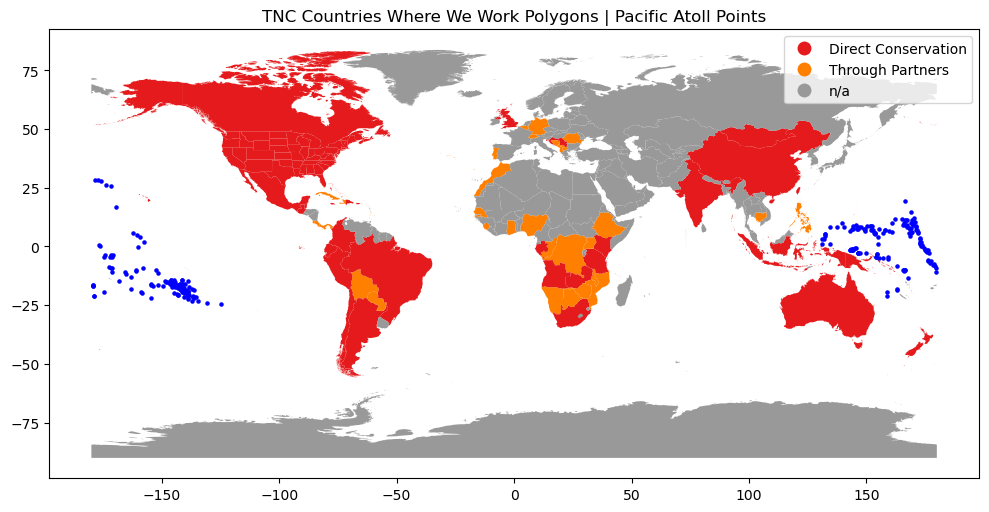

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
os.environ["AWS_NO_SIGN_REQUEST"] = "YES" # Required for SMSL

countries = gpd.read_file("s3://ocs-training-2026/intermediate/tnc_countries.geojson")
atolls = gpd.read_file("s3://ocs-training-2026/intermediate/266_pacific_atolls.geojson")

axes = countries.plot(column='Work_Type', cmap='Set1', legend=True, figsize=(12, 8))
atolls.plot(ax=axes, color="blue", markersize=5)

plt.title('TNC Countries Where We Work Polygons | Pacific Atoll Points')
plt.show()

## Conclusions

We've demonstrated the following concept in this workbook:
- In AWS S3 bucket terminology, `files` are referred to as `objects`. Objects can be grouped by `prefixes` similar to `folders`.
- AWS provides both command line and python packages for interacting with S3 buckets.
- Within the Sagemaker environment, we can interact with data remotely on S3. No need to pull it down to our local workstation (or even Sagemaker's local storage).

## Additional Resources

- [AWS Skill Builder](https://skillbuilder.aws/): This training portal provided by AWS contains self-paced training modules for all of AWS' cloud storage and compute services. While many of the courses are behind a paywall, many of the introductory courses are free to access. Use the web application's filtering function to focus your search, for example to [`Free` courses of the `Fundamental` skill level focused on `Data analytics`](https://skillbuilder.aws/category/domain/data-analytics?page=1&accessTier=free&courseLevel=fundamental)
- [AWS CLI S3 Commands Reference](https://docs.aws.amazon.com/cli/v1/userguide/cli-services-s3-commands.html): Nicely organized examples. For the older `1.X` version of the AWS CLI, but still applicable.
- [AWS CLI S3 Latest Docs](https://docs.aws.amazon.com/cli/latest/reference/s3/): The official manual for the AWS CLI S3 utility. See the list of [available commands](https://docs.aws.amazon.com/cli/latest/reference/s3/#available-commands) for further information.
- [Amazon S3 examples using SDK for Python (Boto3)](https://docs.aws.amazon.com/code-library/latest/ug/python_3_s3_code_examples.html): Numerous examples for using **Python** to interact with S3 buckets using the official `boto3` python package.